[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/12_monsters_and_mixtures.ipynb)

# Chapter 12 - Monsters and Mixtures


## Imports and utility functions


In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2.X
    
    !pip install watermark
    !pip install arviz
    
USE_NIGHTLY_TFP = True # @param
if IN_COLAB and USE_NIGHTLY_TFP:
    !pip install --upgrade tf-nightly
    !pip install --upgrade tfp-nightly

In [2]:
%load_ext watermark

In [3]:
from functools import partial

# Core
import numpy as np
import arviz as az
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy 1.18.2
tensorflow 2.2.0-dev20200417
tensorflow_probability 0.11.0-dev20200417
arviz 0.7.0
scipy 1.4.1
pandas 1.0.3


In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [6]:
if not USE_NIGHTLY_TFP:
    assert tf.__version__ >= '2.1.0', "Tensorflow version should be at minimum 2.1.0"
    assert tfp.__version__ >= '0.9.0', "TFP version should be at minimum 0.9.0"

### Tensorflow MCMC sampling helpers

In [7]:
USE_XLA = False

In [8]:
NUMBER_OF_CHAINS  = 2
NUMBER_OF_BURNIN  = 500
NUMBER_OF_SAMPLES = 500
NUMBER_OF_LEAPFROG_STEPS = 4

def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: np.swapaxes(v.numpy(), 1, 0)
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )

@tf.function(autograph=False, experimental_compile=USE_XLA)
def run_chain(init_state,
              bijectors, 
              step_size, 
              target_log_prob_fn, 
              num_leapfrog_steps=NUMBER_OF_LEAPFROG_STEPS,
              num_samples=NUMBER_OF_SAMPLES,
              burnin=NUMBER_OF_BURNIN,
              ):    

    def _trace_fn_transitioned(_, pkr):
        return (
            pkr.inner_results.inner_results.log_accept_ratio
        )

    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn,
                    num_leapfrog_steps=num_leapfrog_steps,
                    step_size=step_size)         

    inner_kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc_kernel,
        bijector=bijectors)       

    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*burnin),
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )    

    results, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=kernel,
        trace_fn=_trace_fn_transitioned)

    return results, sampler_stat

def sample_posterior(jdc, 
                      observed_data, 
                      params, 
                      num_chains=NUMBER_OF_CHAINS,
                      init_state=None, 
                      bijectors=None,                              
                      num_samples=NUMBER_OF_SAMPLES, 
                      burnin=NUMBER_OF_BURNIN):       
    
    if init_state is None:
        init_state = list(jdc.sample(NUMBER_OF_CHAINS)[:-1])
        
    if bijectors is None:
        bijectors = [tfb.Identity() for i in init_state]


    target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)    
    step_size = 0.1
    results, sample_stats = run_chain(init_state,
                                  bijectors,
                                  step_size=step_size,
                                  target_log_prob_fn=target_log_prob_fn,                                      
                                  num_samples=num_samples, 
                                  burnin=burnin)

    stat_names = ['mean_tree_accept']
    sampler_stats = dict(zip(stat_names, [sample_stats]))    
    posterior = dict(zip(params, results))
    return _trace_to_arviz(trace=posterior, sample_stats=sampler_stats)

### Dataset URLs


In [9]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/ksachdeva/rethinking-tensorflow-probability/master/data"

UCBADMIT_DATASET_PATH = f"{_BASE_URL}/UCBadmit.csv"
KLINE_DATASET_PATH = f"{_BASE_URL}/Kline.csv"

## Code 12.1


A beta distribution is a probability distribution for probabilities !

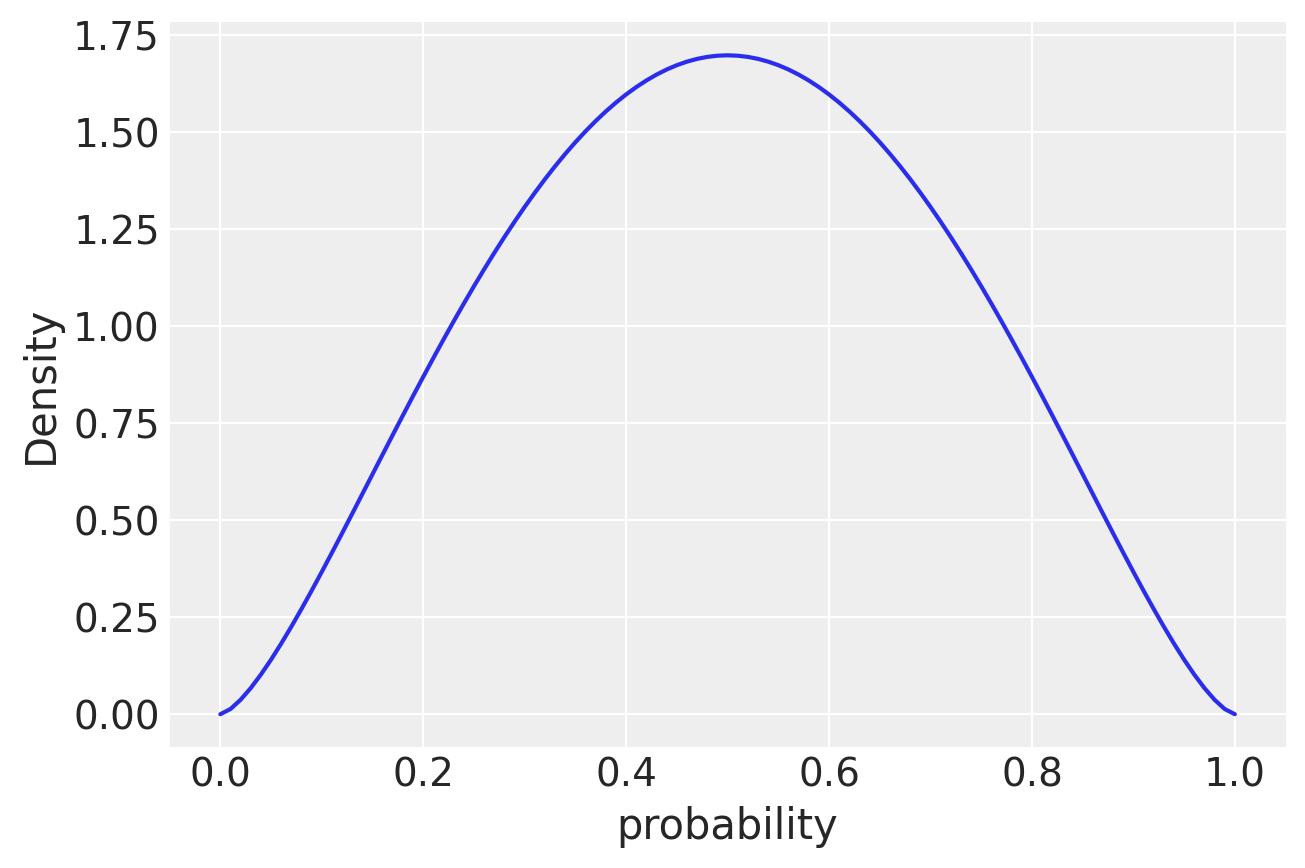

In [10]:
pbar = 0.5   # mean
theta = 5    # total concentration

alpha = pbar * theta
beta = (1 - pbar) * theta

x = np.linspace(0, 1, 101)

plt.plot(x, tf.exp(tfd.Beta(alpha, beta).log_prob(x)))
plt.gca().set(xlabel="probability", ylabel="Density");

## Code 12.2

In [11]:
d = pd.read_csv(UCBADMIT_DATASET_PATH, sep=";")
d["gid"] = (d["applicant.gender"] != "male").astype(int)

In [12]:
def model_12_1(gid, N):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=2))
      phi = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      theta = phi + 2
      pbar = tf.sigmoid(tf.squeeze(tf.gather(alpha, gid, axis=-1)))        
        
      # prepare the concentration vector
      concentration1 = pbar * theta[...,tf.newaxis]
      concentration0 = (1 - pbar) * theta[...,tf.newaxis]    
    
      concentration = tf.stack([concentration1, concentration0], axis=-1)
        
      # outcome A i.e. admit  
      # since it is a multinomial we will have K = 2
      # note -  this does not really behave like Binomial in terms of the sample shape
      A = yield tfd.Independent(tfd.DirichletMultinomial(total_count=N, concentration=concentration), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_12_1 = model_12_1(d.gid.values, tf.cast(d.applications.values, dtype=tf.float32))


## Code 12.3

In [13]:
# Prepare the expected shape by the DirichletMultinomial  
admit_values = tf.constant(d.admit.values, dtype=tf.float32)
reject_values = tf.constant(d.reject.values, dtype=tf.float32)
obs_values = tf.stack([admit_values, reject_values], axis=-1)

In [14]:
NUMBER_OF_CHAINS_12_1 = 2

init_state = [
    tf.zeros([NUMBER_OF_CHAINS_12_1, 2]),
    tf.ones([NUMBER_OF_CHAINS_12_1])
]

bijectors = [
    tfb.Identity(),
    tfb.Identity()
]


trace_12_1 = sample_posterior(
    jdc_12_1, 
    num_samples=1000,
    observed_data=(obs_values,), 
    init_state=init_state,
    bijectors=bijectors,
    params=['alpha', 'phi'])

In [15]:
posterior_12_1 = trace_12_1.posterior

# compute the difference between alphas
posterior_12_1["da"] = posterior_12_1["alpha"][:,:,0] - \
        posterior_12_1["alpha"][:,:,1]

# compute theta
posterior_12_1["theta"] = posterior_12_1["phi"] + 2

In [16]:
az.summary(trace_12_1, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.413,0.421,-1.060,0.239,0.016,0.011,682.0,682.0,686.0,728.0,1.00
alpha[1],-0.321,0.444,-0.956,0.438,0.016,0.012,733.0,669.0,732.0,549.0,1.00
phi,0.674,0.940,-0.826,2.010,0.092,0.084,103.0,64.0,141.0,83.0,1.01
da,-0.092,0.598,-1.041,0.884,0.021,0.015,818.0,760.0,816.0,840.0,1.00
theta,2.674,0.940,1.174,4.010,0.092,0.075,103.0,79.0,141.0,83.0,1.01


## Code 12.4

In [17]:
# Since we have two chains and data is stored in InferenceData format
# we have to manually extract it
#
# Here I am using the data from chain 0
sample_alpha = posterior_12_1["alpha"][0,:].values
sample_theta = posterior_12_1["theta"][0,:].values

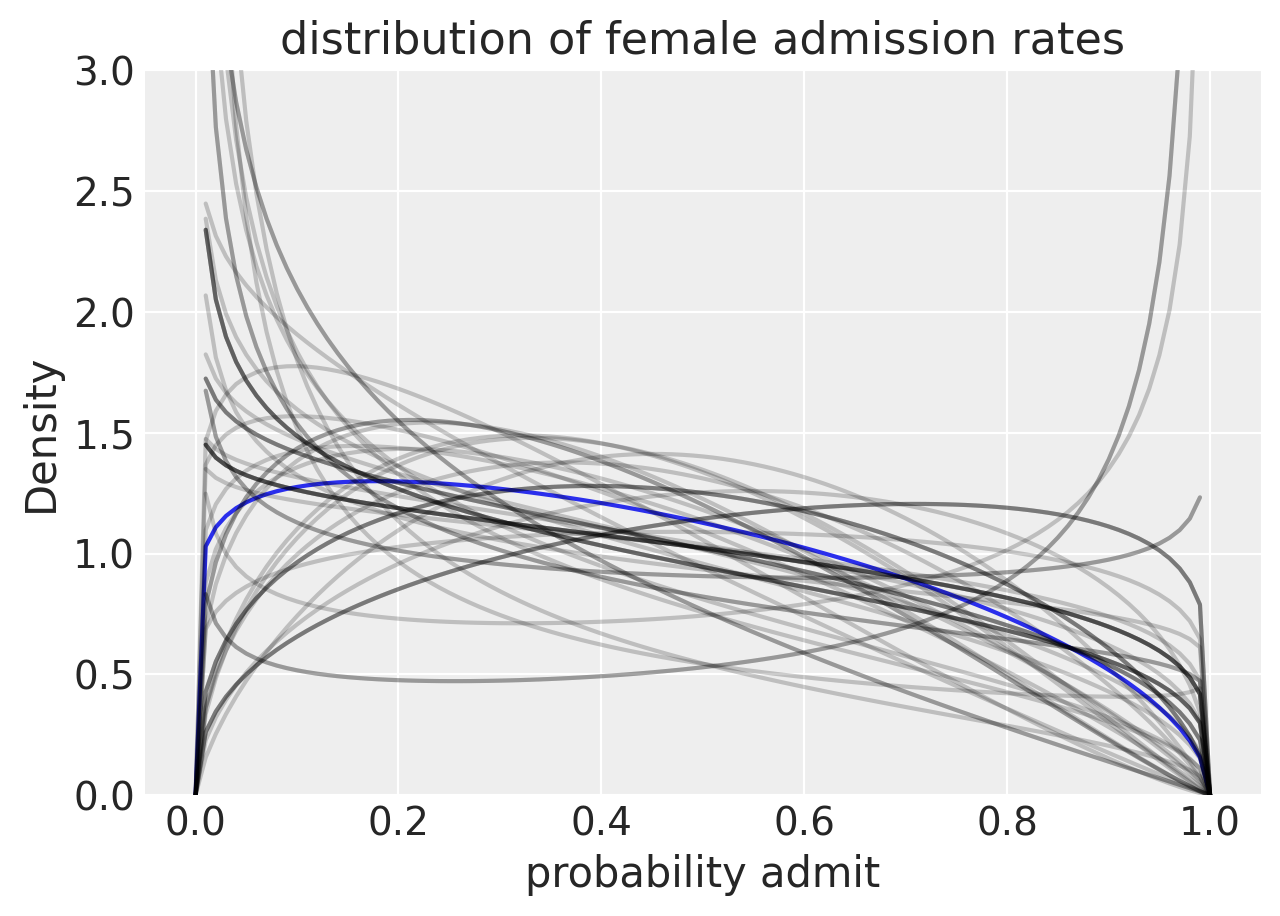

In [18]:
gid = 1
# draw posterior mean beta distribution
x = np.linspace(0, 1, 101)
pbar = tf.reduce_mean(tf.sigmoid(sample_alpha[:, gid]))
theta = tf.reduce_mean(sample_theta)
plt.plot(x, tf.exp(tfd.Beta(pbar * theta, (1 - pbar) * theta).log_prob(x)))
plt.gca().set(ylabel="Density", xlabel="probability admit", ylim=(0, 3));

# draw 50 beta distributions sampled from posterior
for i in range(50):
    p = tf.sigmoid(sample_alpha[i, gid])
    theta = sample_theta[i]
    plt.plot(x, tf.exp(tfd.Beta(p * theta, (1 - p) * theta).log_prob(x)),
             "k", alpha=0.2)
plt.title("distribution of female admission rates");

## Code 12.5

In [19]:
# get samples given the posterior distribution
N = tf.cast(d.applications.values, dtype=tf.float32)
gid = d.gid.values

sample_pbar = tf.sigmoid(tf.squeeze(tf.gather(sample_alpha, gid, axis=-1)))    

# need to reshape it to make it happy
st = tf.reshape(sample_theta, shape=(1000,1))

# prepare the concentration vector
concentration1 = sample_pbar * st
concentration0 = (1 - sample_pbar) * st    

concentration = tf.stack([concentration1, concentration0], axis=-1)

dist = tfd.DirichletMultinomial(total_count=N, concentration=concentration)

predictive_samples = dist.sample()

In [20]:
# numpy style indexing magic ! .. hate it !
admit_rate = predictive_samples[::,::,0] / N

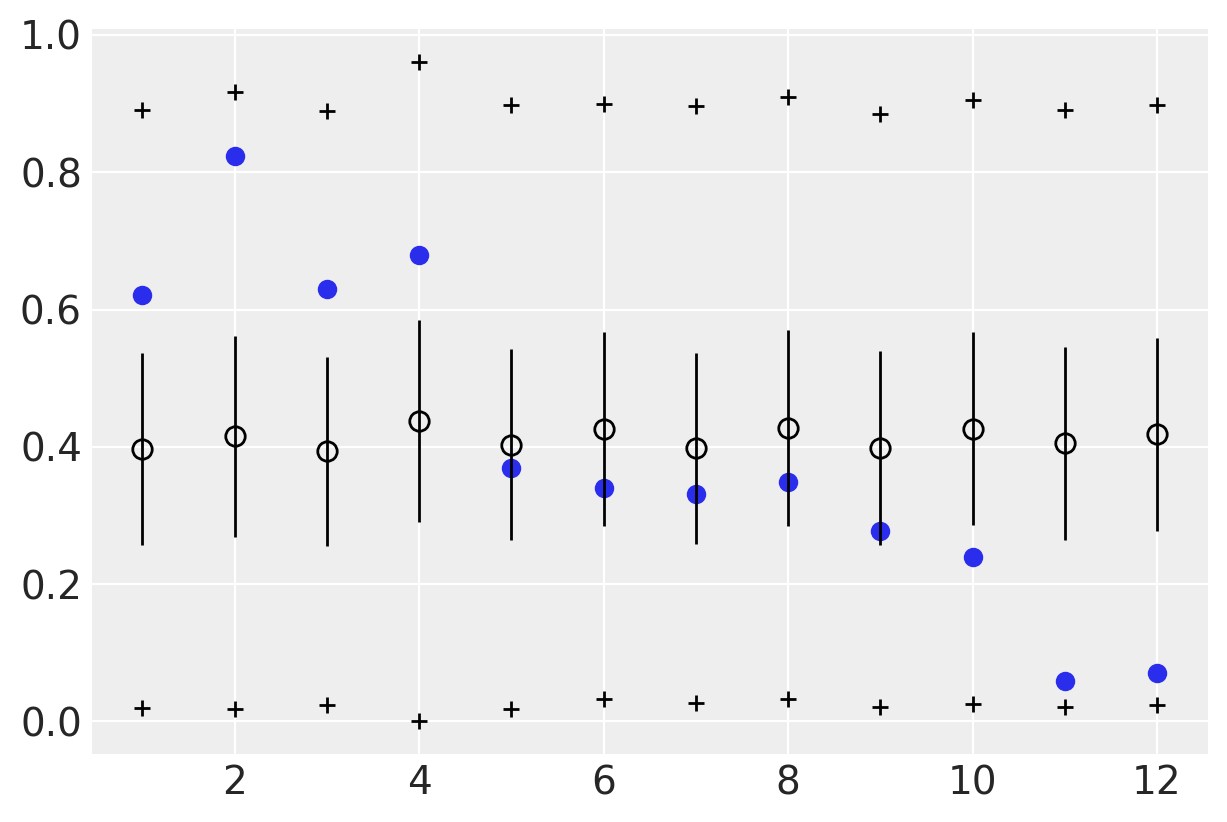

In [21]:
plt.scatter(range(1, 13), d.admit.values /N)
plt.errorbar(range(1, 13), np.mean(admit_rate, 0), np.std(admit_rate, 0) / 2,
             fmt="o", c="k", mfc="none", ms=7, elinewidth=1)
plt.plot(range(1, 13), np.percentile(admit_rate, 5.5, 0), "k+")
plt.plot(range(1, 13), np.percentile(admit_rate, 94.5, 0), "k+");

In the above plot, the vertifical axis shows the predicted proportion admitted, for each case on the horizontal.

Blue points show the empirical proportion admitted on each row of data

Open circles are the posterior mean pbar and + symbols mark the 89% interval of predicted counts of admission

## Code 12.6  (Not working !)

Start to use **Gamma-Poisson** (also known as **Negative Binomial**) models.

Essentially Gamm-Poisson is about associating a rate to each Posisson count observation. Estimates the shape of gamma distribution to describe the Poisson rates across cases.

Gamma-Poisson also expects more variation around the mean rate.

The negative binomial distribution arises naturally from a probability experiment of performing a series of independent Bernoulli trials until the occurrence of the rth success where r is a positive integer.

In [22]:
d = pd.read_csv(KLINE_DATASET_PATH, sep=";")
d["P"] = d.population.pipe(np.log).pipe(lambda x: (x - x.mean()) / x.std())
d["cid"] = (d.contact == "high").astype(int)

d.head()

,culture,population,contact,total_tools,mean_TU,P,cid
0,Malekula,1100,low,13,3.2,-1.291473,0
1,Tikopia,1500,low,22,4.7,-1.088551,0
2,Santa Cruz,3600,low,24,4.0,-0.515765,0
3,Yap,4791,high,43,5.0,-0.328773,1
4,Lau Fiji,7400,high,33,5.0,-0.044339,1


In [ ]:
def model_12_2(cid, P):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=1., scale=1.), sample_shape=2))
      beta = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=2))
      gamma = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      phi = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))

      lambda_ = tf.exp(tf.squeeze(tf.gather(alpha, cid, axis=-1))) * \
              tf.math.pow(P, tf.squeeze(tf.gather(beta, cid, axis=-1))) / gamma
    
      g_concentration = lambda_ / phi
      g_rate = 1 / phi
    
      t1 = yield tfd.Independent(
          tfd.Gamma(concentration=g_concentration, rate=g_rate), reinterpreted_batch_ndims=1)
        
      T = yield tfd.Independent(tfd.Poisson(rate=t1), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_12_2 = model_12_2(d.cid.values, tf.cast(d.P.values, dtype=tf.float32))

jdc_12_2.sample()

In [ ]:
NUMBER_OF_CHAINS_12_2 = 1

alpha_init, beta_init, gamma_init, phi_init, t1_init, _ = jdc_12_2.sample(2)

init_state = [
    alpha_init,
    beta_init,
    gamma_init,
    phi_init,
    t1_init
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.Exp(),
    tfb.Exp(),
    tfb.Identity(),
]

trace_12_2 = sample_posterior(jdc_12_2, 
                                   observed_data=(d.total_tools.values,),
                                   init_state=init_state,
                                   bijectors=bijectors,
                                   params=['alpha', 'beta', 'gamma' 'phi', 't1'])

In [ ]:
az.summary(trace_12_2, credible_interval=0.89)